In [80]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

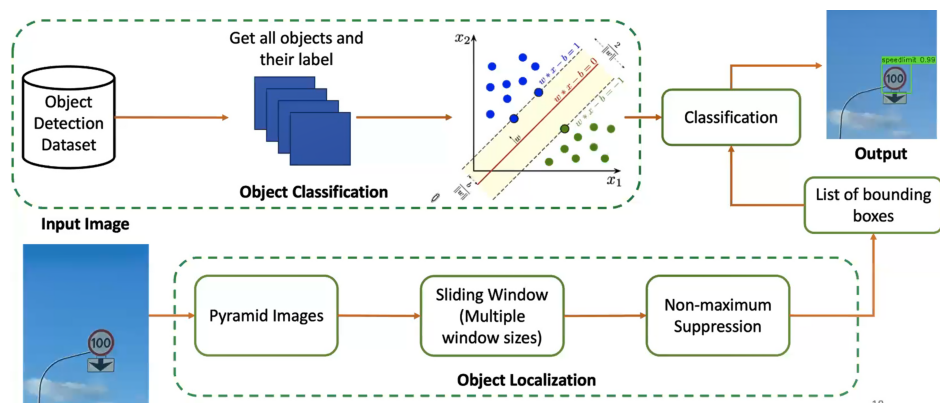

In [81]:
image = cv2.imread("Project pipeline.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Hiển thị tấm hình
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')  
plt.show()

Object Classification

Đọc dataset 

In [82]:
annotations_dir = 'traffic_sign_detection/annotations'
img_dir = 'traffic_sign_detection/images'
img_lst = []
label_lst = []




File xml trông như này 


<annotation> 
    <folder>images</folder>
    <filename>road0.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>62</ymin>
            <xmax>208</xmax>
            <ymax>232</ymax>
        </bndbox>
    </object>
</annotation>

In [83]:
img_dir = 'traffic_sign_detection/images'
img_filename_lst = os.listdir(img_dir)[100:110]
conf_threshold = 0.95
stride = 12
window_sizes = [(32,32),(64,64),(128,128)]
for xml_file in os.listdir ( annotations_dir ) :

    xml_filepath= os.path.join ( annotations_dir , xml_file )     # lấy đường dẫn đến từng file xml trong annotation ra 

    
    tree = ET.parse ( xml_filepath )# Đọc file xml bằng xml.etree.ElementTree
    root = tree.getroot () # lấy root trong file xml cụ thể là thẻ <annotation>
    folder = root.find ('folder').text
    img_filename = root.find ('filename').text
    img_filepath = os. path.join ( img_dir , img_filename )# tạo đường dẫn đến file ảnh 
    img = cv2.imread ( img_filepath ) # đọc file ảnh 

    for obj in root.findall('object'): # lấy toàn bộ object có trong 1 file xml ra 
        classname = obj.find('name').text
        # không đọc các object là đèn giao thông 
        # vì đề tài là nhận diện biển báo xóa không đọc để đỡ hao 
        if (classname == 'trafficlight'):
            continue 
        # lấy tọa độ của object ra 
        
        xmin = int(obj.find ('bndbox/xmin').text )
        ymin = int(obj.find ('bndbox/ymin').text )
        xmax = int(obj.find ('bndbox/xmax').text )
        ymax = int(obj.find ('bndbox/ymax').text )
        
        # cắt hình object 
        object_img = img[ymin :ymax , xmin : xmax]

        # cho vào 2 mảng ban đầu là label với img 
        img_lst.append (object_img)
        label_lst.append (classname)
 

Bước 2 tiền xử lí dữ liệu 

đổi hinh của từng obj về HoG rồi chuyển về vector 1D

In [84]:
def preprocess_img (img ) :
    if len(img.shape ) > 2:
        img = cv2.cvtColor (img ,cv2 . COLOR_BGR2GRAY)# chuyển sang ảnh xám nếu không phải 
    img = img. astype (np. float32 )

    resized_img = resize (img ,output_shape =(32 , 32) ,anti_aliasing = True) # resize tấm ảnh về 32,32 để tất cả các object đều bằng nhau 
    # chuyển ảnh sang dịnh dạng HOG rồi chuyển về vectỏ 1-D là 9,1 thay vì ảnh ban đầu là vector 3-D
    hog_feature = feature.hog(resized_img ,orientations =9 ,# 9 bin
        pixels_per_cell =(8 , 8) ,cells_per_block =(2 , 2) , # lấy 1 cell là 8x8 và 1 block là 4 cell tức 2x2 
        transform_sqrt =True ,block_norm ="L2",
        feature_vector = True )

    return hog_feature

Apply hàm vào toàn bộ hình

In [85]:
img_features_lst = []
for img in img_lst :
    hog_feature = preprocess_img(img)
    img_features_lst.append( hog_feature )

img_features = np.array ( img_features_lst )

Encode cho output

In [86]:
label_encoder = LabelEncoder ()
encoded_labels = label_encoder.fit_transform( label_lst )

Chia dữ liệu 

In [87]:
random_state = 0
test_size = 0.3
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (img_features , encoded_labels ,
    test_size = test_size ,
    random_state = random_state )

In [88]:
scaler = StandardScaler ()
X_train = scaler.fit_transform ( X_train )
X_val = scaler.transform ( X_val )


In [89]:
from sklearn.metrics import f1_score
lst_gamma = [1e-2, 1e-3, 1e-4]
lst_score_train = []
lst_score_test = []
lst_C = []
lst_gamma_dtframe= []
lst_f1= []
for gammaIndex in range(3):
        
        for i in [0.1, 0.5,1,5, 10,50, 100,500, 1000]:

                clf = SVC(kernel ='rbf',random_state = random_state ,
                        probability =True ,C =(i),gamma= lst_gamma[gammaIndex]) # lấy probability =True để xài đuọc hàm predic prob để lấy tỉ lệ của từng label 
                clf.fit( X_train , y_train )
                y_pred_test = clf.predict ( X_val )
                y_pred_train = clf.predict ( X_train )
                score_train = accuracy_score (y_pred_train , y_train )
                score_test= accuracy_score (y_pred_test , y_val )
                f1 = f1_score(y_pred_test, y_val,average='macro')
                lst_score_train.append(score_train)
                lst_score_test.append(score_test)
                lst_f1.append(f1)
                lst_C.append(i*5)
                lst_gamma_dtframe.append(lst_gamma[gammaIndex])

cv_results = pd.DataFrame()
cv_results['score_test'] =     lst_score_test
cv_results['score_train'] =lst_score_train
cv_results['gamma'] = lst_gamma_dtframe
cv_results['C'] = lst_C
cv_results['f1'] = lst_f1
cv_results 

,score_test,score_train,gamma,C,f1
0,0.753894,0.733601,0.0100,0.5,0.310468
1,0.862928,0.966533,0.0100,2.5,0.697958
2,0.912773,1.000000,0.0100,5.0,0.831459
3,0.915888,1.000000,0.0100,25.0,0.841508
4,0.915888,1.000000,0.0100,50.0,0.841508
5,0.915888,1.000000,0.0100,250.0,0.841508
6,0.915888,1.000000,0.0100,500.0,0.841508
7,0.915888,1.000000,0.0100,2500.0,0.841508
8,0.915888,1.000000,0.0100,5000.0,0.841508
9,0.947040,0.951807,0.0010,0.5,0.852090


In [90]:
from sklearn.metrics import f1_score
lst_gamma = [1e-2, 1e-3, 1e-4]
lst_score_train = []
lst_score_test = []
lst_C = []
lst_gamma_dtframe= []
lst_f1= []

        
for i in [0.1, 0.5,1,5, 10,50, 100,500, 1000]:

        clf = SVC(kernel ='poly',random_state = random_state ,
                probability =True ,C =(i)) # lấy probability =True để xài đuọc hàm predic prob để lấy tỉ lệ của từng label 
        clf.fit( X_train , y_train )
        y_pred_test = clf.predict ( X_val )
        y_pred_train = clf.predict ( X_train )
        score_train = accuracy_score (y_pred_train , y_train )
        score_test= accuracy_score (y_pred_test , y_val )
        
        lst_score_train.append(score_train)
        lst_score_test.append(score_test)
        lst_f1.append(f1)
        lst_C.append(i*5)
        

cv_results_poly = pd.DataFrame()
cv_results_poly['score_test'] =     lst_score_test
cv_results_poly['score_train'] =lst_score_train

cv_results_poly['C'] = lst_C
cv_results_poly['f1'] = lst_f1
cv_results_poly 

,score_test,score_train,C,f1
0,0.956386,0.986613,0.5,0.993246
1,0.981308,0.998661,2.5,0.993246
2,0.984424,1.000000,5.0,0.993246
3,0.984424,1.000000,25.0,0.993246
4,0.984424,1.000000,50.0,0.993246
5,0.984424,1.000000,250.0,0.993246
6,0.984424,1.000000,500.0,0.993246
7,0.984424,1.000000,2500.0,0.993246
8,0.984424,1.000000,5000.0,0.993246


<Figure size 640x480 with 0 Axes>

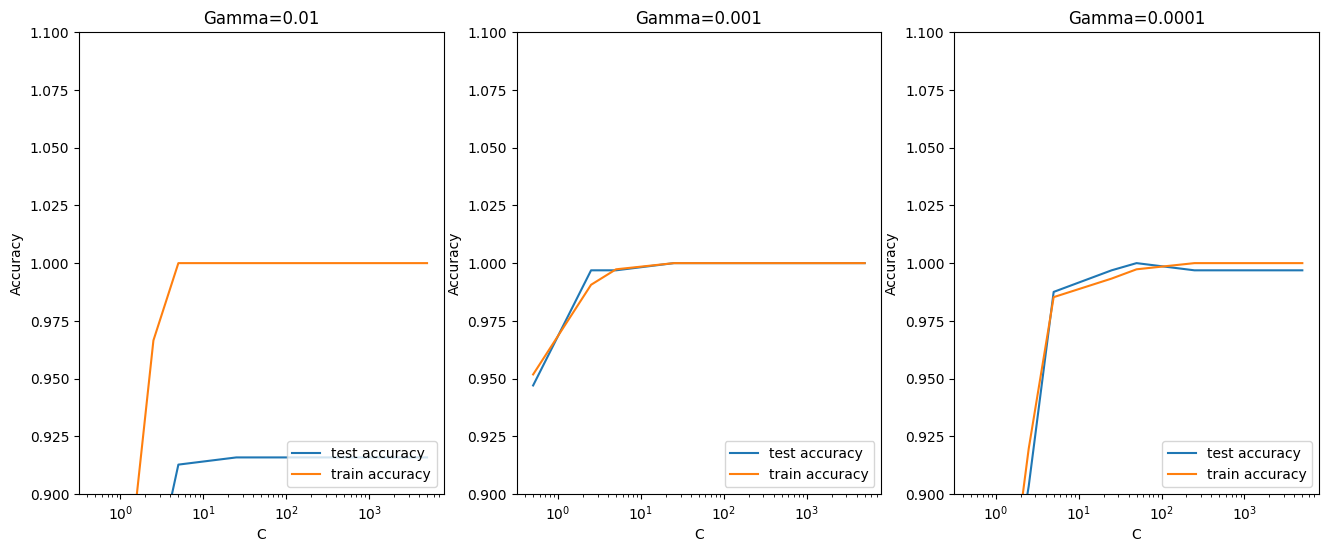

In [91]:

plt.suptitle("Accuracy for RBF kernel with different Gammas", fontsize=16)

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['gamma']==0.01]

plt.plot(gamma_01["C"], gamma_01["score_test"])
plt.plot(gamma_01["C"], gamma_01["score_train"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.9, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['gamma']==0.001]

plt.plot(gamma_001["C"], gamma_001["score_test"])
plt.plot(gamma_001["C"], gamma_001["score_train"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.9, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['gamma']==0.0001]

plt.plot(gamma_0001["C"], gamma_0001["score_test"])
plt.plot(gamma_0001["C"], gamma_0001["score_train"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.9, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

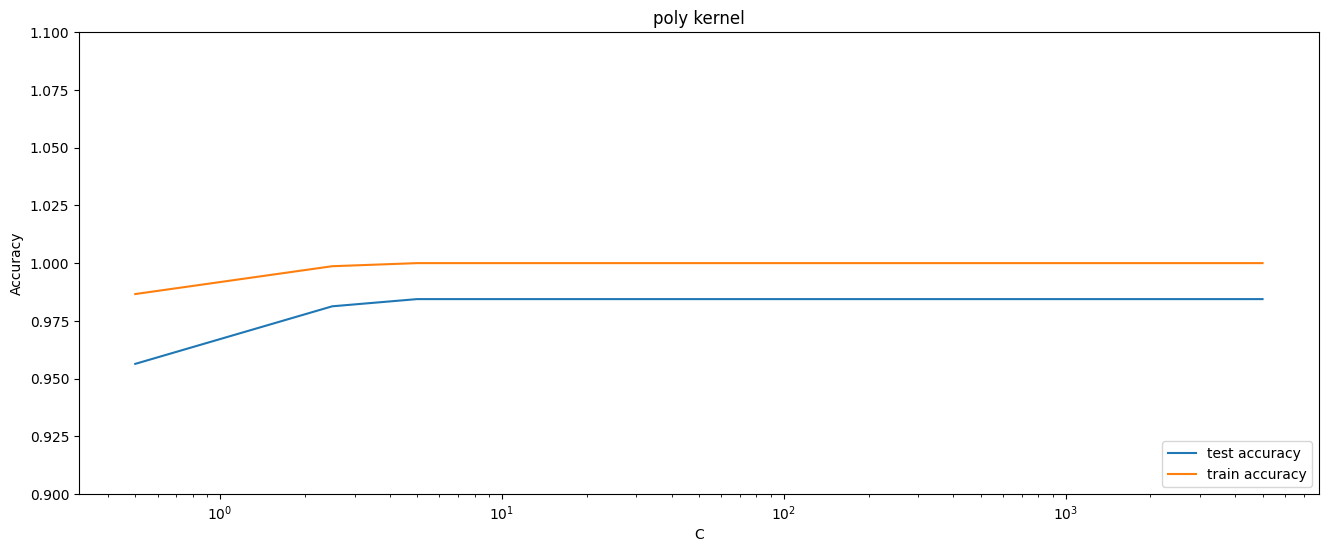

In [92]:


# # plotting
plt.figure(figsize=(16,6))



plt.plot(cv_results_poly["C"], cv_results_poly["score_test"])
plt.plot(cv_results_poly["C"], cv_results_poly["score_train"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("poly kernel")
plt.ylim([0.9, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

In [93]:
clf = SVC(kernel ='rbf',random_state = random_state ,
          probability =True ,C =10) # lấy probability =True để xài đuọc hàm predic prob để lấy tỉ lệ của từng label 
clf.fit( X_train , y_train )

y_pred = clf.predict ( X_val )
score = accuracy_score (y_pred , y_val )

print ('Evaluation results on val set ')
print ('Accuracy : ', score )


Evaluation results on val set 
Accuracy :  0.9906542056074766


Object Localization

Tìm vị trí của object 


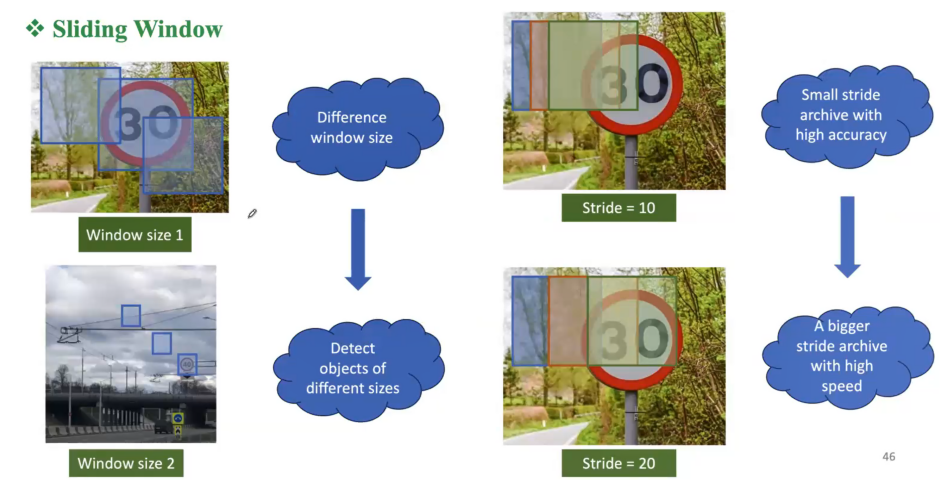

In [94]:
image = cv2.imread("Sliding window.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Hiển thị tấm hình
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')  
plt.show()

In [95]:
def sliding_window (img , window_sizes , stride ) :
    img_height , img_width = img. shape [:2]
    windows = []
    for window_size in window_sizes :
        window_width , window_height = window_size
        for ymin in range (0 , img_height - window_height + 1 , stride ) :
            for xmin in range (0 , img_width - window_width + 1 , stride ) :
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append ([ xmin , ymin , xmax , ymax ])

    return windows


Kỹ thuật sliding window có rất nhiều mặt hạn chế. Một trong số đó là việc tìm kiếm các object có kích thước nhỏ.Để phần nào khắc phục được tình trạng này, ta có thể áp dụng kỹ thuật Pyramid Image. Về cơ bản, kỹ thuật này sẽ tạo ra một chuỗi các ảnh với kích thước nhỏ dần. Khi đó, các object nhỏ trong ảnh gốc sẽ to hơn khi ở trong ảnh nhỏ. Từ đó, ta áp dụng sliding window trên chuỗi ảnh với hy vọng có thể tìm được object nhỏ có trong ảnh gốc.

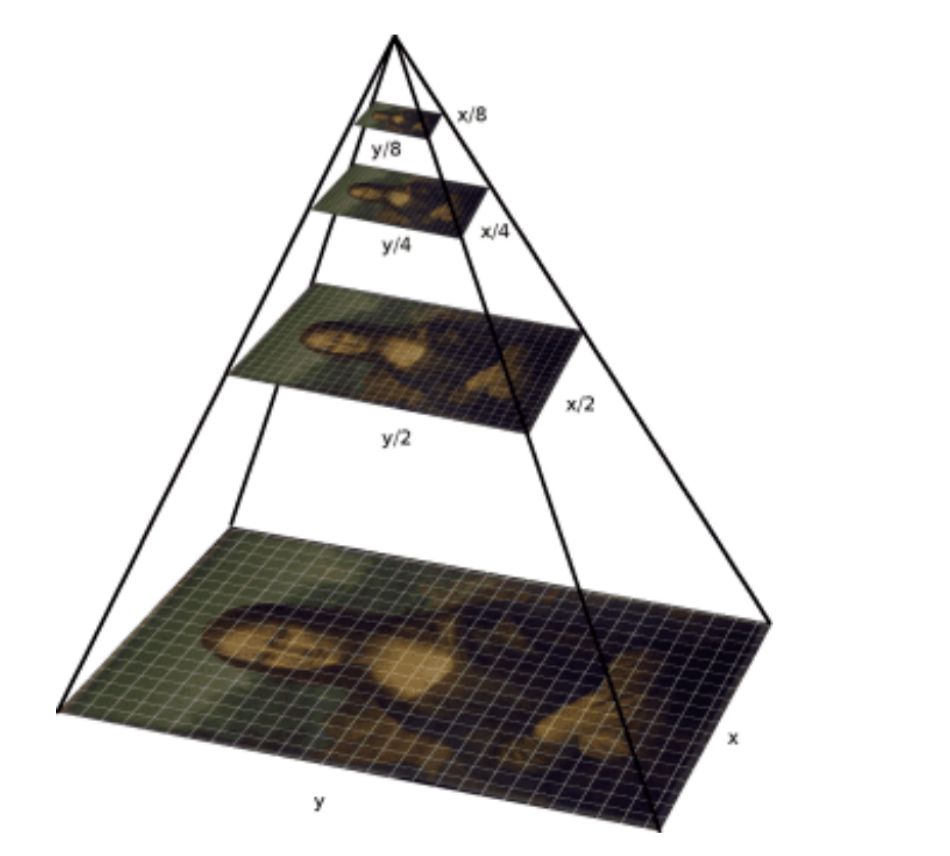

In [96]:
image = cv2.imread("Pyramid Image.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Hiển thị tấm hình
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')  
plt.show()

In [97]:
def pyramid (img , scale =0.8 , min_size =(30 , 30) ) : # scale tỉ lệ scale mỗi lần, mínize tỉ lệ ảnh nhỏ nhất cho phép

    acc_scale = 1.0 
    pyramid_imgs = [( img , acc_scale ) ] # mảng chứa ảnh mỗi lần scale

    while True :
        #scale lại ảnhh
        acc_scale = acc_scale * scale
        h = int (img. shape [0] * acc_scale )
        w = int (img. shape [1] * acc_scale )
        if h < min_size [1] or w < min_size [0]:
            break
        img = cv2. resize (img , (w, h) )

        #thêm vào danh sách ảnh 
        pyramid_imgs.append (( img , acc_scale ) )

    return pyramid_imgs

Vẽ bounding box lên 

In [98]:
def visualize_bbox (img , bboxes , label_encoder ) :
    img = cv2.cvtColor (img , cv2.COLOR_BGR2RGB )

    for box in bboxes :
        xmin , ymin , xmax , ymax , predict_id , conf_score = box

        cv2.rectangle (img , (xmin , ymin ) , (xmax , ymax ) , (0 , 255 , 0) , 2)
        classname = label_encoder.inverse_transform ([ predict_id ]) [0]
        label = f"{ classname } { conf_score :.2f}"
        (w, h) , _ = cv2.getTextSize (label , cv2.FONT_HERSHEY_SIMPLEX , 0.6 , 1)
        cv2.rectangle (img , (xmin , ymin - 20) , ( xmin + w, ymin ) , (0 , 255 , 0) , -1)
        cv2.putText (img , label , (xmin , ymin - 5) , cv2.FONT_HERSHEY_SIMPLEX , 0.6 ,
        (0 , 0 , 0) , 1)

    plt.imshow (img)
    plt.axis ('off')
    plt.show ()

Prediction từng tấm ảnh 

Non-Maximum Suppression
Kỹ thuật NMS sẽ loại bỏ các bounding box nằm đè nhau và chỉ giữ lại bounding box có confidence core là cao nhất. Để xây dựng hàm NMS, đầu tiên, ta triển khai hàm tính IoU (Intersection over Union). IoU là tỉ lệ giao nhau giữa hai bounding box, có công thức tính như sau :Công thức tính IoU là tỉ lệ giữa diện tích phần giao nhau và diện tích tổng thể của hai bounding box

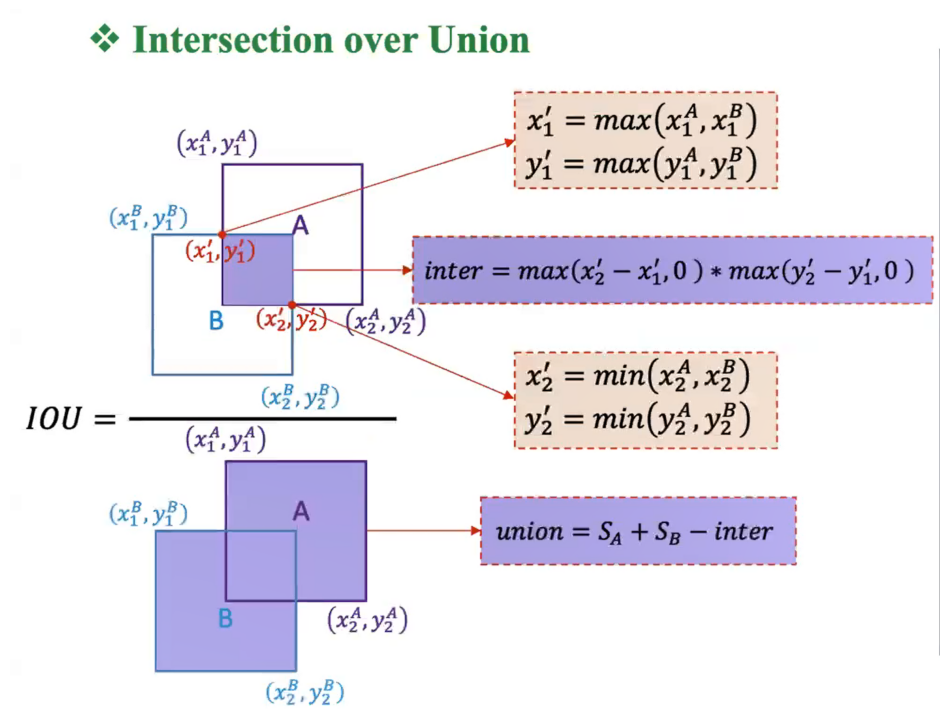

In [99]:
image = cv2.imread("IoU.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Hiển thị tấm hình
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')  
plt.show()

In [100]:
def compute_iou (bbox , bboxes , bbox_area , bboxes_area ) :
    xxmin = np. maximum ( bbox [0] , bboxes [: , 0])
    yymin = np. maximum ( bbox [1] , bboxes [: , 1])
    xxmax = np. minimum ( bbox [2] , bboxes [: , 2])
    yymax = np. minimum ( bbox [3] , bboxes [: , 3])

    w = np. maximum (0 , xxmax - xxmin + 1)
    h = np. maximum (0 , yymax - yymin + 1)

    intersection = w * h
    iou = intersection / ( bbox_area + bboxes_area - intersection )

    return iou

In [101]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []
    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)
        iou = compute_iou([xmin[i],ymin[i],xmax[i],ymax[i]],
                          np.array([
                              xmin[sorted_indices[1:]],
                              ymin[sorted_indices[1:]],
                              xmax[sorted_indices[1:]],
                              ymax[sorted_indices[1:]]
                          ]).T,
                          areas[i],
                          areas[sorted_indices[1:]])
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep+1]
    return [bboxes[i] for i in keep]

Predict

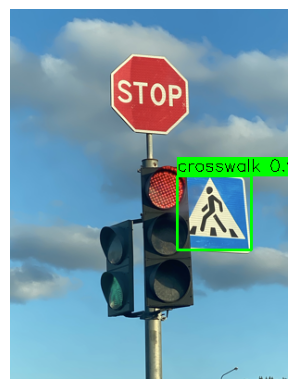

traffic_sign_detection/images_test\road823.png
Time process: 3.3219823837280273


In [102]:
img_dir = 'traffic_sign_detection/images_test'
img_filename_lst = os.listdir(img_dir)
conf_threshold = 0.95
stride = 12
window_sizes = [(32,32),(64,64),(128,128)]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir,img_filename)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(pyramid_img, window_sizes=window_sizes, stride=stride)

        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]

            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymin = int(ymin / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])
    bboxes = nms(bboxes,0.1)
    if bboxes:
        visualize_bbox(img, bboxes=bboxes, label_encoder=label_encoder)
        print(img_filepath)
        print(f'Time process: {time.time() - start_time}')